In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=Warning)
# Load the data from the identified sheet
df = pd.read_excel("Healthcare Merged Dataset.xlsx")

# Display the first few rows to inspect the data structure
df.head()

,ID,Patient Information,Symptoms & History
0,1,"Name: Robert M., Age: 42, Gender: Male","Doctor, I’ve been feeling dizzy whenever I exe..."
1,2,"Name: Sarah T., Age: 25, Gender: Female","My face keeps breaking out, especially around ..."
2,3,"Name: John D., Age: 50, Gender: Male",I’ve been feeling weak and fatigued throughout...
3,4,"Name: Emily S., Age: 28, Gender: Female",There’s a painful knot in my shoulder blade th...
4,5,"Name: Michael B., Age: 34, Gender: Male","When I wake up in the morning, my body feels e..."


In [2]:
# Basic overview of the dataset
overview = df.info()

print(overview)

# Checking for missing values
missing_values = df.isnull().sum()

print(missing_values)

# Summary statistics for text length in "Symptoms & History"
df['Text_Length'] = df['Symptoms & History'].apply(lambda x: len(str(x).split()))
text_stats = df['Text_Length'].describe()
print(text_stats)

# Identifying the most common words
#from collections import Counter
#word_count = Counter(" ".join(df['Symptoms & History'].astype(str)).split()).most_common(10)

#print(word_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   544 non-null    int64 
 1   Patient Information  544 non-null    object
 2   Symptoms & History   544 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.9+ KB
None
ID                     0
Patient Information    0
Symptoms & History     0
dtype: int64
count    544.000000
mean      27.854779
std       11.223129
min        9.000000
25%       20.750000
50%       28.000000
75%       35.000000
max       59.000000
Name: Text_Length, dtype: float64


In [3]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Custom stop words specific to medical context
custom_stopwords = {
    "could", "would", "should", "might", "like", "just", "really", "started", 
    "feel", "specific", "issue", "condition", "history", "health"
}

# Define the complete cleaning function
def clean_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and lowercase
    # Lemmatize, remove custom stopwords, stop words, short words, and non-alphabetic words
    return [lemmatizer.lemmatize(word) for word in tokens 
            if word.isalpha() and word not in stop_words 
            and word not in custom_stopwords and len(word) >= 2]

# Apply the cleaning function to the "Symptoms & History" column
df['Cleaned_Text'] = df['Symptoms & History'].apply(clean_text)

# Flatten list for word frequency analysis
all_words_filtered = [word for tokens in df['Cleaned_Text'] for word in tokens]

# Analyze the most frequent words
common_words_filtered = Counter(all_words_filtered).most_common(10)

# Bigram analysis for co-occurring words
bigrams = list(ngrams(all_words_filtered, 2))
common_bigrams_filtered = Counter(bigrams).most_common(10)

common_words_filtered, common_bigrams_filtered

([('condition', 134),
  ('issue', 126),
  ('infection', 122),
  ('pain', 104),
  ('family', 102),
  ('chronic', 102),
  ('ago', 100),
  ('indicate', 100),
  ('range', 100),
  ('possible', 100)],
 [(('indicate', 'range'), 100),
  (('range', 'possible'), 100),
  (('possible', 'condition'), 100),
  (('condition', 'viral'), 100),
  (('viral', 'infection'), 100),
  (('infection', 'chronic'), 100),
  (('chronic', 'issue'), 100),
  (('issue', 'diagnosis'), 100),
  (('diagnosis', 'test'), 100),
  (('test', 'required'), 100)])

### 1. Analyze Common Symptoms & Conditions

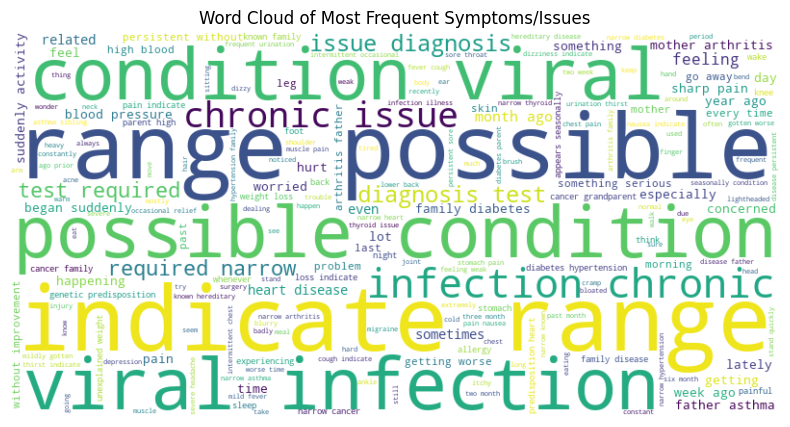

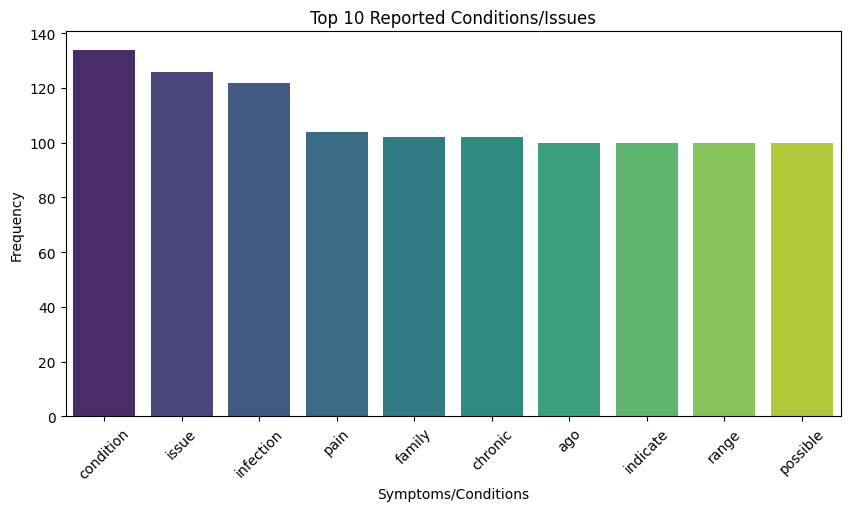

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Generate Word Cloud for common words (symptoms/issues)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words_filtered))

# Plot Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Frequent Symptoms/Issues")
plt.show()

# Create Bar Chart for Top 10 Conditions/Issues
top_10 = Counter(all_words_filtered).most_common(10)
words, counts = zip(*top_10)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title("Top 10 Reported Conditions/Issues")
plt.xlabel("Symptoms/Conditions")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

### Perform Sentiment Analysis

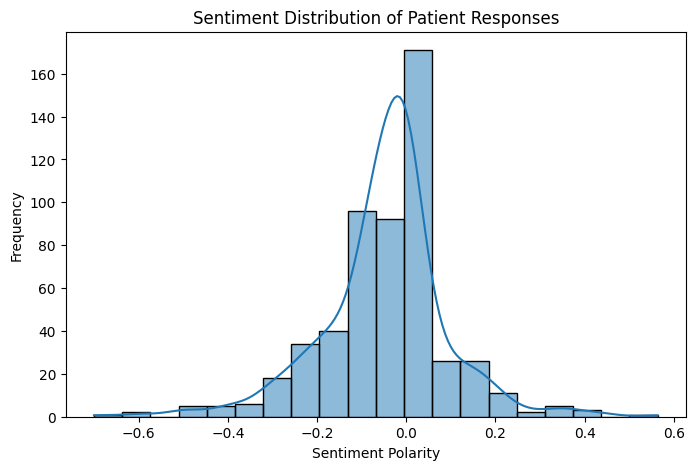

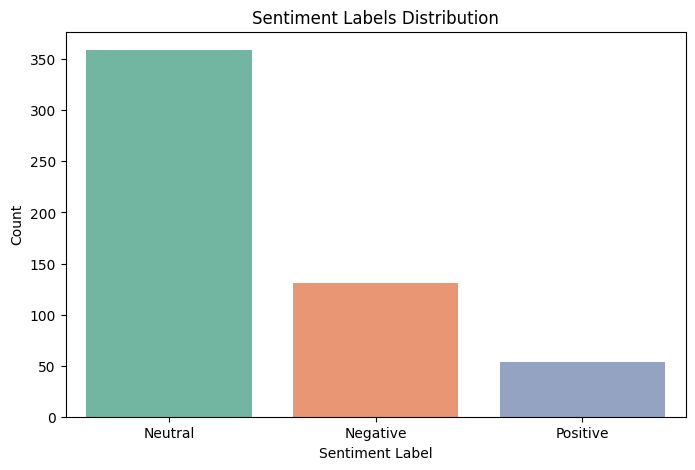

In [5]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Analysis
df['Sentiment'] = df['Symptoms & History'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize sentiments
def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Label'] = df['Sentiment'].apply(categorize_sentiment)

# Plot Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution of Patient Responses")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

# Plot Sentiment Labels Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Label', data=df, palette="Set2")
plt.title("Sentiment Labels Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

### 3. Topic Modeling (Optional Advanced Step)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Symptoms & History'])

# Apply NMF for topic modeling
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X)

# Display Top Words in Each Topic
for i, topic in enumerate(nmf_model.components_):
    print(f"Top words for topic #{i+1}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:][::-1]])

Top words for topic #1:
['issues', 'possible', 'viral', 'range', 'indicate', 'diagnosis', 'required', 'tests', 'narrow', 'infections']
Top words for topic #2:
['family', 'history', 'improvement', 'persistent', 'cancer', 'hypertension', 'diabetes', 'diseases', 'known', 'relief']
Top words for topic #3:
['began', 'activity', 'suddenly', 'arthritis', 'father', 'asthma', 'mother', 'predisposition', 'genetic', 'disease']
Top words for topic #4:
['ve', 'started', 'ago', 'feel', 'feeling', 'time', 'related', 'pain', 'months', 'worse']
Top words for topic #5:
['blood', 'high', 'pressure', 'parents', 'seasonally', 'appears', 'specific', 'illness', 'infection', 'conditions']


### 4. Insights & Reporting

#### Frequency Analysis of Symptoms

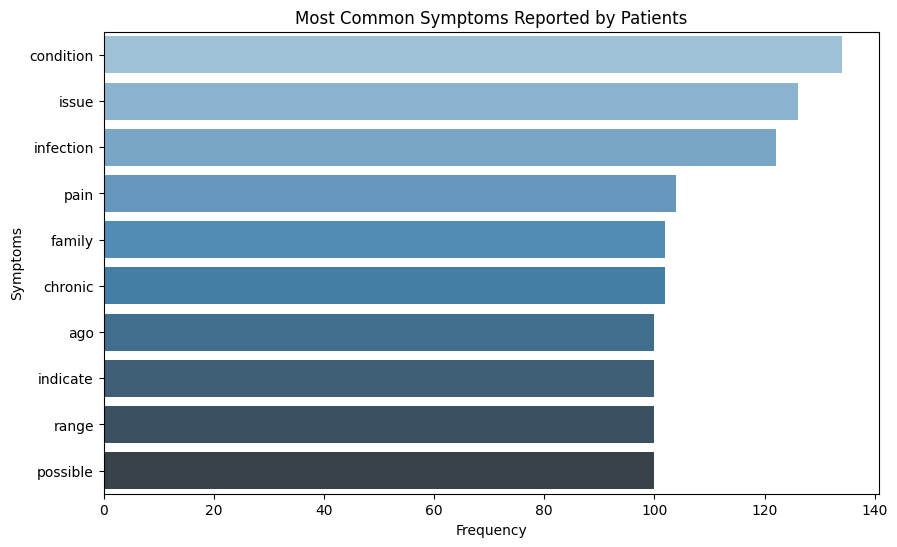

In [8]:
# Frequency Analysis of Symptoms
from collections import Counter

# Flatten list for word frequency analysis
all_words_filtered = [word for tokens in df['Cleaned_Text'] for word in tokens]

# Analyze the most frequent words
common_words_filtered = Counter(all_words_filtered).most_common(10)

# Plotting the most common symptoms
common_words = [item[0] for item in common_words_filtered]
common_word_freq = [item[1] for item in common_words_filtered]

plt.figure(figsize=(10, 6))
sns.barplot(x=common_word_freq, y=common_words, palette="Blues_d")
plt.title("Most Common Symptoms Reported by Patients")
plt.xlabel("Frequency")
plt.ylabel("Symptoms")
plt.show()

#### 2. Co-occurring Issues (Bigrams Analysis)

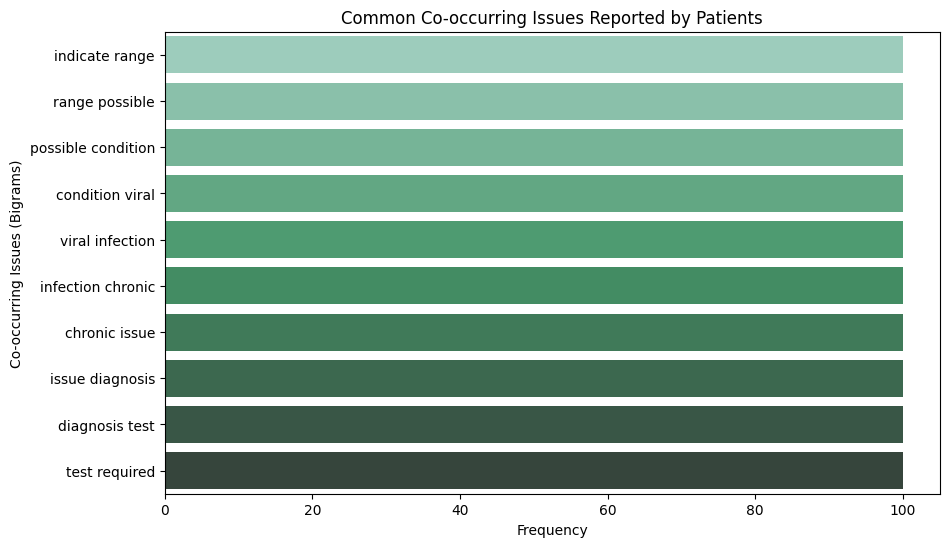

In [12]:
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Generate bigrams from the filtered words
bigrams = list(ngrams(all_words_filtered, 2))

# Get the 10 most common bigrams
common_bigrams_filtered = Counter(bigrams).most_common(10)

# Prepare the data for plotting
common_bigrams = [' '.join(item[0]) for item in common_bigrams_filtered]
bigram_freq = [item[1] for item in common_bigrams_filtered]

# Plotting the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=bigram_freq, y=common_bigrams, palette="BuGn_d")
plt.title("Common Co-occurring Issues Reported by Patients")
plt.xlabel("Frequency")
plt.ylabel("Co-occurring Issues (Bigrams)")
plt.show()

#### 3. Emotional Tone of Patient Responses

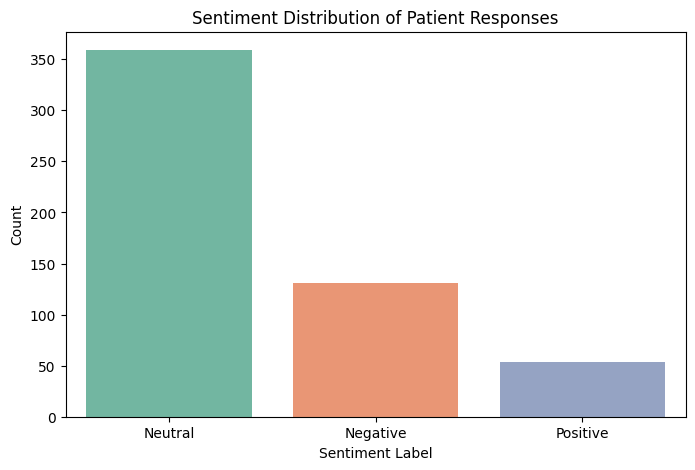

In [10]:
# Plot Sentiment Labels Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Label', data=df, palette="Set2")
plt.title("Sentiment Distribution of Patient Responses")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

In [ ]:
#### 4. Potential Clusters Indicating Specific Conditions

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizing the cleaned text data
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Symptoms & History'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Get the top words for each topic
n_words = 10
feature_names = vectorizer.get_feature_names_out()

topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-n_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    topics.append(" ".join(top_words))

# Display the topics
for idx, topic in enumerate(topics):
    print(f"Topic {idx+1}: {topic}")

Topic 1: conditions specific issues cause health infections chronic range viral narrow
Topic 2: history ve family started ago persistent improvement months skin feels
Topic 3: ve started feel ago feeling months don history related mother
Topic 4: heart pressure ve blood disease feel feeling high started like
Topic 5: pain started ve history ago worse time sharp related lower


#### Extract the data

In [20]:
import pandas as pd
import re
from datetime import datetime


# Function to extract age, gender, and name from the 'Patient Information'
def extract_patient_info(info):
    name = re.search(r'Name:\s*([A-Za-z\s]+)', info)
    age = re.search(r'Age:\s*(\d+)', info)
    gender = re.search(r'Gender:\s*(Male|Female)', info)
    
    return {
        'Name': name.group(1) if name else None,
        'Age': int(age.group(1)) if age else None,
        'Gender': gender.group(1) if gender else None
    }

# Function to extract medical information from 'Symptoms & History'
def extract_medical_history(symptoms):
    # Extract primary symptoms, duration, severity, and medical history
    symptoms_data = {
        'Primary Symptoms': re.findall(r'(\bfever\b|\bheadache\b|\bpain\b|\bdizziness\b|\bweakness\b)', symptoms, re.IGNORECASE),
        'Duration of Symptoms': re.search(r'for (\d+\s*days|\w+)', symptoms),
        'Severity': re.search(r'(mild|moderate|severe)', symptoms, re.IGNORECASE),
        'Medical History': re.findall(r'(hypertension|diabetes|cholesterol|allergies)', symptoms, re.IGNORECASE),
        'Current Medications': re.findall(r'([A-Za-z]+\s+\d+mg)', symptoms),
    }
    
    symptoms_data['Duration of Symptoms'] = symptoms_data['Duration of Symptoms'].group(1) if symptoms_data['Duration of Symptoms'] else None
    symptoms_data['Severity'] = symptoms_data['Severity'].group(1) if symptoms_data['Severity'] else None
    
    return symptoms_data

# Function to extract lifestyle habits (smoking, alcohol, exercise, diet, sleep)
def extract_lifestyle_habits(symptoms):
    lifestyle = {
        'Smoking': 'Yes' if re.search(r'smoking|smoke', symptoms, re.IGNORECASE) else 'No',
        'Alcohol Consumption': 'Yes' if re.search(r'(\balcohol\b|\bdrinking\b)', symptoms, re.IGNORECASE) else 'No',
        'Exercise Routine': 'Yes' if re.search(r'exercise', symptoms, re.IGNORECASE) else 'No',
        'Dietary Habits': 'Vegetarian' if re.search(r'vegetarian', symptoms, re.IGNORECASE) else 'Non-Vegetarian',
        'Sleep Pattern': re.search(r'(\d+)\s*hours of sleep', symptoms),
    }
    
    lifestyle['Sleep Pattern'] = lifestyle['Sleep Pattern'].group(1) if lifestyle['Sleep Pattern'] else 'Unknown'
    
    return lifestyle

# Apply the functions to extract data
df_patient_info = df['Patient Information'].apply(extract_patient_info)
print(" --------------------df_patient_info--------------------")
print(df_patient_info.head())

df_medical_history = df['Symptoms & History'].apply(extract_medical_history)
print("--------------------df_medical_history--------------------")
print(df_medical_history)

df_lifestyle_habits = df['Symptoms & History'].apply(extract_lifestyle_habits)
print("--------------------df_lifestyle_habits--------------------")
print(df_lifestyle_habits)


# Combine all the extracted data
final_df = pd.concat([df_patient_info, df_medical_history, df_lifestyle_habits], axis=1)

# Display the final DataFrame with the extracted information
# print(final_df)

 --------------------df_patient_info--------------------
0    {'Name': 'Robert M', 'Age': 42, 'Gender': 'Male'}
1    {'Name': 'Sarah T', 'Age': 25, 'Gender': 'Fema...
2      {'Name': 'John D', 'Age': 50, 'Gender': 'Male'}
3    {'Name': 'Emily S', 'Age': 28, 'Gender': 'Fema...
4    {'Name': 'Michael B', 'Age': 34, 'Gender': 'Ma...
Name: Patient Information, dtype: object
--------------------df_medical_history--------------------
0      {'Primary Symptoms': [], 'Duration of Symptoms...
1      {'Primary Symptoms': [], 'Duration of Symptoms...
2      {'Primary Symptoms': [], 'Duration of Symptoms...
3      {'Primary Symptoms': ['pain'], 'Duration of Sy...
4      {'Primary Symptoms': [], 'Duration of Symptoms...
                             ...                        
539    {'Primary Symptoms': [], 'Duration of Symptoms...
540    {'Primary Symptoms': [], 'Duration of Symptoms...
541    {'Primary Symptoms': [], 'Duration of Symptoms...
542    {'Primary Symptoms': ['pain'], 'Duration of Sy..

In [18]:
final_df.head()

,Patient Information,Symptoms & History,Symptoms & History
0,"{'Name': 'Robert M', 'Age': 42, 'Gender': 'Male'}","{'Primary Symptoms': [], 'Duration of Symptoms...","{'Smoking': 'No', 'Alcohol Consumption': 'No',..."
1,"{'Name': 'Sarah T', 'Age': 25, 'Gender': 'Fema...","{'Primary Symptoms': [], 'Duration of Symptoms...","{'Smoking': 'No', 'Alcohol Consumption': 'No',..."
2,"{'Name': 'John D', 'Age': 50, 'Gender': 'Male'}","{'Primary Symptoms': [], 'Duration of Symptoms...","{'Smoking': 'No', 'Alcohol Consumption': 'No',..."
3,"{'Name': 'Emily S', 'Age': 28, 'Gender': 'Fema...","{'Primary Symptoms': ['pain'], 'Duration of Sy...","{'Smoking': 'No', 'Alcohol Consumption': 'No',..."
4,"{'Name': 'Michael B', 'Age': 34, 'Gender': 'Ma...","{'Primary Symptoms': [], 'Duration of Symptoms...","{'Smoking': 'No', 'Alcohol Consumption': 'No',..."
